In [30]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, regularizers, models
from keras.models import load_model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from util import save_history, save_model, plot_metrics, plot_visualizations

In [7]:
model_version = "v9.0"
base_model_version = 'v9.0'

In [9]:
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [10]:
with open('data_schema.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photo_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

In [11]:
df = pd.read_csv(f"data/processed/photometry_only.csv")

X = df[photo_cols + generic_cols]
y = df[target_col]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
base_model = load_model(f'models/{base_model_version}/spec_photo_model.h5')

base_model.trainable = False

base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 58)]              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                3776      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 Dense_128 (Dense)           (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 Dense_256 (Dense)           (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0     

In [22]:
input_shape = X_train_scaled.shape[1]
inputs = tf.keras.Input(shape=(input_shape,))
x = layers.Dense(64, activation='relu', name='new_input_layer')(inputs)

# ✅ Integrate base layers from index 2 onward
for layer in base_model.layers[2:]:
    x = layer(x)

# 🔧 Transfer head
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Transfer_Dense_128')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Transfer_Dense_64')(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1)(x)

transfer_model = models.Model(inputs=inputs, outputs=outputs)
transfer_model.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='mean_squared_error',
                       metrics=['mae', 'mse', 'mape'])

early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                         patience=30,
                                         restore_best_weights=True)

transfer_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 39)]              0         
                                                                 
 new_input_layer (Dense)     (None, 64)                2560      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 Dense_128 (Dense)           (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 Dense_256 (Dense)           (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0   

In [24]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)
history = transfer_model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/200
4467/4467 [==============================] - 30s 7ms/step - loss: 4.5255 - mae: 1.5878 - mse: 4.4613 - mape: 15.0176 - val_loss: 0.6141 - val_mae: 0.6896 - val_mse: 0.5555 - val_mape: 6.4790
Epoch 2/200
4467/4467 [==============================] - 34s 8ms/step - loss: 2.3956 - mae: 1.2226 - mse: 2.3391 - mape: 11.5855 - val_loss: 0.4214 - val_mae: 0.5574 - val_mse: 0.3678 - val_mape: 5.2613
Epoch 3/200
4467/4467 [==============================] - 54s 12ms/step - loss: 2.1086 - mae: 1.1448 - mse: 2.0589 - mape: 10.8532 - val_loss: 0.3436 - val_mae: 0.4931 - val_mse: 0.2979 - val_mape: 4.6609
Epoch 4/200
4467/4467 [==============================] - 54s 12ms/step - loss: 1.8583 - mae: 1.0745 - mse: 1.8157 - mape: 10.1909 - val_loss: 0.2504 - val_mae: 0.3837 - val_mse: 0.2102 - val_mape: 3.6590
Epoch 5/200
4467/4467 [==============================] - 52s 12ms/step - loss: 1.6067 - mae: 0.9972 - mse: 1.5680 - mape: 9.4683 - val_loss: 0.2089 - val_mae: 0.2986 - val_mse: 0.1714 - 

In [25]:
y_pred = transfer_model.predict(X_test_scaled)

1396/1396 [==============================] - 3s 2ms/step


In [26]:
plot_metrics(y_test, y_pred)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.1537
Root Mean Squared Error (RMSE): 0.2941
R² Score: 0.8014


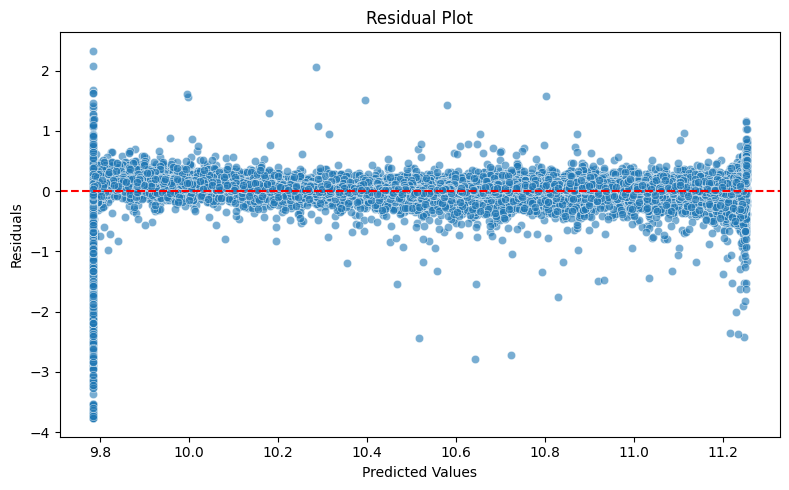

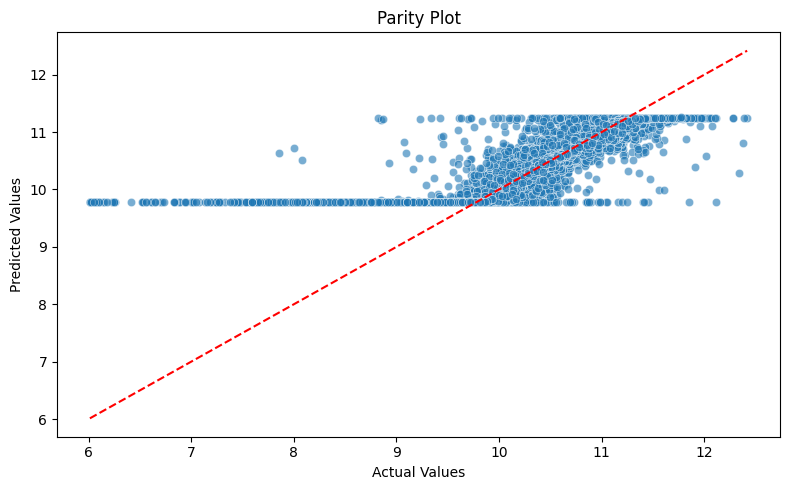

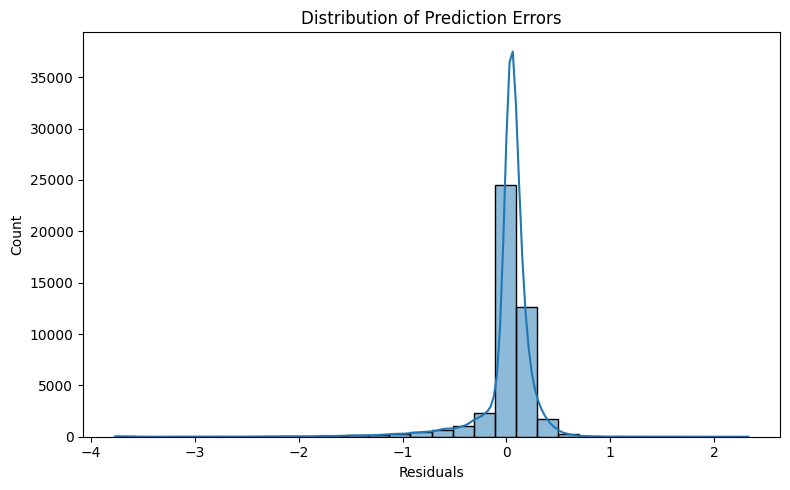

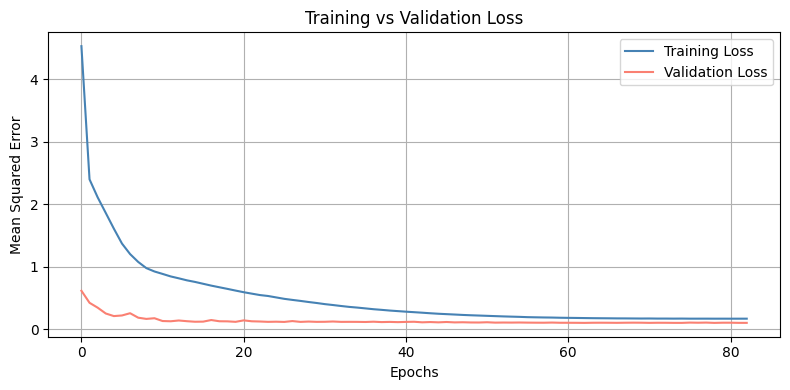

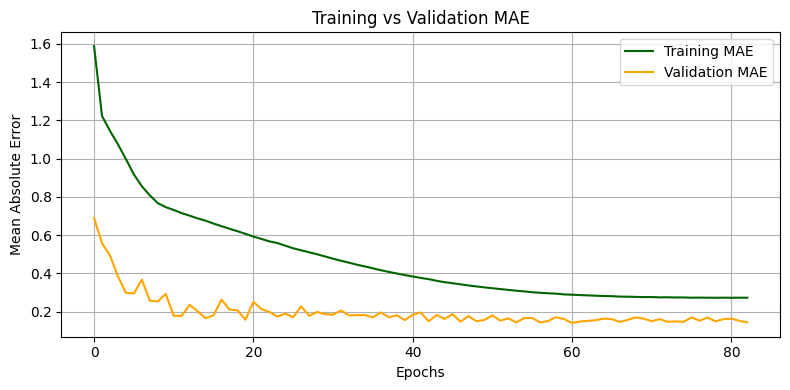

In [27]:
plot_visualizations(history, y_test, y_pred)

In [32]:
def save_model(model, model_version, model_name='spec_photo_model'):
    os.makedirs(f'models/{model_version}', exist_ok=True)
    model.save(f'models/{model_version}/{model_name}.h5')
    
def save_history(history, model_version, history_name='history'):
    os.makedirs(f'history/{model_version}', exist_ok=True)

    history_path = os.path.join(f'history/{model_version}', f'{history_name}.json')
    with open(history_path, 'w') as f:
        json.dump(history.history, f)

In [34]:
save_history(history, model_version, 'history_photo_only')

In [35]:
save_model(transfer_model, model_version, 'photo_only_model')